In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import datetime
from catboost import CatBoostClassifier
import lightgbm as lgb
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import ast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn import linear_model

from tqdm import tqdm_notebook as tqdm
import gc, pickle

import datetime
from catboost import CatBoostClassifier
from time import time
from collections import Counter
from scipy import stats

from sklearn import preprocessing

In [2]:
def create_is_sell_data(sell_prices_df, calendar_df, train_df):
    sell_prices_df['id'] = sell_prices_df['item_id'].astype('str')+'_'+sell_prices_df['store_id']+'_validation'
    sell_prices_data = sell_prices_df[sell_prices_df.wm_yr_wk.isin(calendar_df.wm_yr_wk.unique())]
    sell_prices_data.reset_index(drop=True, inplace=True)
    tmp = sell_prices_data.groupby(['id'])[['wm_yr_wk', 'sell_price']].apply(
        lambda x: x.set_index('wm_yr_wk')['sell_price'].to_dict()
    ).to_dict()
    d = calendar_df.d
    wm_yr_wk = calendar_df.wm_yr_wk
    price_data = {}
    for col in tqdm(train_df.id.unique()):
        price_data[col] = wm_yr_wk.map(tmp[col])
    price_data = pd.DataFrame(price_data)
    price_data.index = d
    is_sell = price_data.notnull().astype(float).T
    price_data = price_data.fillna(0)
    
    is_sell.index=train_df.id
    train_df.index=train_df.id
    is_sell = pd.concat([
        train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], is_sell
    ], axis=1)
    price_data = pd.concat([
        train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], price_data.T  
    ], axis=1)
    
    return price_data, is_sell

def set_index(df, name):
    d = {}
    for col, value in df.iloc[0,:].items():
        if type(col)==str:
            if type(df[col].values[0])!=str:
                v = 'd'
            else:
                v='id'
        else:
            v=name
        d[col]=v
    return d

def dcol2int(col):
    if col[:2]=='d_':
        return int(col.replace('d_', ''))
    else:
        return col

In [3]:
def create_category_data(data, dfT):
    C = ['item_id', 'cat_id', 'dept_id', 'store_id', 'state_id']
    tmp = dfT[C]
    tmp = tmp.to_dict()
    for key, value in tmp.items():
        data[key] = data.id.map(value)
    return data

def create_calendar_data(data, calendar_df):
    calendar_data_dict = calendar_df[['wday', 'month']].to_dict()
    for key, value in calendar_data_dict.items():
        data[key] = data.d.map(value)
    
    for shift in [-2,-1,0,1,2]:
        cols = []
        for state in ['CA', 'WI', 'TX']:
            tmp = calendar_df[f'snap_{state}'].shift(shift).to_dict()
            data[f'snap_{state}_shift{shift}'] = data.d.map(tmp)
            cols.append(f'snap_{state}_shift{shift}')
        data[f'snap_shift{shift}'] = np.nan
        for col in cols:
            state = col.replace('snap_', '').replace(f'_shift{shift}', '')
            data.loc[data['state_id']==state,f'snap_shift{shift}'] = data[col]
        data.drop(columns=cols, inplace=True)
    return data

def create_groupby_price_data(data, price_data, use_d_cols, groups=['dept_id', 'cat_id']):
    for group in groups:
        tmp = price_data[use_d_cols]/price_data.groupby([group, 'store_id'])[use_d_cols].transform('mean')
        tmp = tmp.T.astype(float)
        tmp = tmp.stack(dropna=False).reset_index()
        tmp = tmp.rename(columns=set_index(tmp, f'price_mean_by_store_{group}'))
        data = pd.merge(data, tmp, on=['d', 'id'], how='left')
        
    tmp = price_data[use_d_cols].stack().reset_index()
    tmp = tmp.rename(columns=set_index(tmp, 'price'))
    tmp.index = tmp.d.astype(str)+'_'+tmp.id.astype(str)
    tmp = tmp.price.to_dict()
    data['price'] = data.d_and_id.map(tmp)
    
    return data

In [4]:
def create_event_data(data, name):
    a = pd.concat([
        train_df.groupby(['item_id'])[d_cols].agg('mean').T.astype(float),
        calendar_df[name]
    ],axis=1)
    
    cols = a.columns[:-1]
    a[name]=a[name].fillna('NAN')
    a[cols] = a.groupby([name])[cols].transform(
        lambda x:x.sort_index().rolling(len(x), min_periods=1).mean().shift(1)
    )/train_df.groupby(['item_id'])[d_cols].agg('mean').T.astype(float).shift(1).rolling(50, min_periods=1).mean()[cols]
    
    a.loc[a[name]=='NAN', cols]=0
    a.loc[a[name]=='NAN', name]=np.nan
    a.drop(name, axis=1, inplace=True)
    
    for shift in [-3,-2,-1,0,1]:
        tmp_a = a.shift(shift).stack().reset_index()
        tmp_a = tmp_a.rename(columns=set_index(tmp_a, 'value'))
        tmp_a.index = tmp_a.id.astype(str)+'_'+tmp_a.d.astype(str)
        tmp_a = tmp_a[tmp_a.index.isin(data.d.unique().tolist())]
        tmp_a.drop(columns=['d', 'id'], inplace=True)
        data[f'{name}_shift{shift}'] = (data.item_id.astype(str)+'_'+data.d.astype(str)).map(tmp_a['value']).apply(
            lambda x: float(x) if float(x)>0 else 0
        )
    del a, tmp_a; gc.collect()
    return data

In [5]:
def create_roll_data(data, df, wins, use_d_cols):
    for win in wins:
        for agg in ['mean', 'std', 'skew']:
            tmp = df[data.id.unique()].rolling(window=win, min_periods=1).agg(agg).loc[use_d_cols].stack(dropna=False).reset_index()
            tmp = tmp.rename(columns=set_index(tmp, f'_diff_roll{win}_{agg}'))
            data = pd.merge(data, tmp, on=['d', 'id'], how='left')
        data[f'_diff_pct_roll{win}'] = data[f'_diff_roll{win}_mean']/data[f'_diff_roll{win}_std']
    return data

def create_diff_data(data, df, i, wins, use_d_cols, name=None):
    a = abs(df.diff(i))
    for win in wins:
        for agg in ['mean']:
            tmp = a.rolling(window=win, min_periods=1).agg(agg).loc[use_d_cols].stack(dropna=False).reset_index()
            if name is None:
                tmp = tmp.rename(columns=set_index(tmp, f'abs_diff_{i}_roll{win}_{agg}'))
            else:
                tmp = tmp.rename(columns=set_index(tmp, f'{name}_abs_diff_{i}_roll{win}_{agg}'))
            data = pd.merge(data, tmp, on=['d', 'id'], how='left')
    return data

def create_group_sell_data(data, dfT, use_d_cols, groups=['dept_id', 'cat_id']):
    for group in groups:
        tmp = dfT[use_d_cols]/ dfT.groupby([group])[use_d_cols].transform('mean')
        tmp = tmp.T.astype(float)
        data = create_diff_data(data, tmp, 7, wins=[360, 30, 28, 7], use_d_cols=use_d_cols, name=f'By_{group}')
        data = create_diff_data(data, tmp, 1, wins=[360, 7], use_d_cols=use_d_cols, name=f'By_{group}')
        data = create_diff_data(data, tmp, 28, wins=[360, 7], use_d_cols=use_d_cols, name=f'By_{group}')
    return data

def create_shift_data(data, df, shifts, use_d_cols, name=None):
    tmp_df = df[data.id.unique()]+df[data.id.unique()].shift(7)+df[data.id.unique()].shift(14)+df[data.id.unique()].shift(21)
    
    for i, shift in enumerate(shifts):
        tmp = tmp_df.shift(shift).loc[use_d_cols].stack(dropna=False).reset_index()
        if name is None:
            tmp = tmp.rename(columns=set_index(tmp, f'shift_no{i+1}'))
        else:
            tmp = tmp.rename(columns=set_index(tmp, f'{name}_shift_no{i+1}'))
        data = pd.merge(data, tmp, on=['d', 'id'], how='left')
    return data

def create_group_shift_data(data, df, dfT, shifts, use_d_cols):
    for group in ['dept_id', 'cat_id']:
        _tmp = dfT.groupby([group])[use_d_cols].transform('mean').T.astype(float)
        data = create_shift_data(data, _tmp, shifts, use_d_cols, name=f'By_{group}')
    return data

In [6]:
%%time
#path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'
#path = '/Users/abcdm/Downloads/m5-forecasting-accuracy/'
path = '../input/m5-forecasting-accuracy/'

train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')


calendar_df['d'] = calendar_df.d.str.replace('d_', '').astype(int)
cols = train_df.columns
cols = [dcol2int(col) for col in cols]
train_df.columns=cols
calendar_df['date']=pd.to_datetime(calendar_df.date)
calendar_df.index = calendar_df.d
price_data, is_sell = create_is_sell_data(sell_prices_df, calendar_df, train_df)

d_cols = [ col for col in train_df.columns if type(col)!=str ]
for i in range(1,29):
    train_df[d_cols[-1]+i]=np.nan
d_cols = [ col for col in train_df.columns if type(col)!=str ]

train_df = pd.concat([
    train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']],
    train_df[d_cols]+is_sell[d_cols].replace(0, np.nan).replace(1, 0)
], axis=1)


CPU times: user 1min 3s, sys: 7.75 s, total: 1min 10s
Wall time: 1min 9s


In [7]:
lag=28
train_d_cols = d_cols[-(lag+100):-lag]

In [8]:
%%time
use_d_cols = [i for i in range(train_d_cols[0]-200,train_d_cols[0])]+train_d_cols
ids = train_df.id.unique().tolist()
    
df = train_df.loc[ids,:]
df = df.T.loc[d_cols]
df = pd.DataFrame(df.values.astype(float), index=d_cols, columns=df.columns)

df['d']=df.index

CPU times: user 16.5 s, sys: 4.53 s, total: 21.1 s
Wall time: 21 s


In [9]:
%%time
calendar_dict = calendar_df[[
    'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2'
]].set_index('d').to_dict()

for key, value in calendar_dict.items():
    df[key] = df['d'].map(value)
df.drop('d', axis=1, inplace=True)

CPU times: user 166 ms, sys: 91.6 ms, total: 258 ms
Wall time: 257 ms


In [10]:
%%time
price_data[
    [col for col in price_data.columns if type(col)!=str]
] = price_data[
    [col for col in price_data.columns if type(col)!=str]
].replace(0, np.nan)

CPU times: user 807 ms, sys: 272 ms, total: 1.08 s
Wall time: 1.08 s


In [11]:
%%time
df = df.loc[use_d_cols]
dfT = train_df.loc[ids,['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]

CPU times: user 72.5 ms, sys: 29.2 ms, total: 102 ms
Wall time: 101 ms


In [12]:
%%time
is_sell = is_sell[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]
price_data = price_data[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]

CPU times: user 29.6 ms, sys: 32.1 ms, total: 61.7 ms
Wall time: 60.4 ms


In [13]:
%%time
data = df.loc[train_d_cols, ids].stack(dropna=False).reset_index().rename(columns={'level_0':'d', 'id':'id', 0:'TARGET'})

CPU times: user 318 ms, sys: 52.7 ms, total: 371 ms
Wall time: 372 ms


In [14]:
data.head()

,d,id,TARGET
0,1814,HOBBIES_1_001_CA_1_validation,0.0
1,1814,HOBBIES_1_002_CA_1_validation,0.0
2,1814,HOBBIES_1_003_CA_1_validation,0.0
3,1814,HOBBIES_1_004_CA_1_validation,3.0
4,1814,HOBBIES_1_005_CA_1_validation,0.0


In [15]:
%%time
data['d_and_id'] = data.d.astype(str)+'_'+data.id.astype(str)

CPU times: user 2.73 s, sys: 274 ms, total: 3.01 s
Wall time: 3 s


In [16]:
%%time
data = create_category_data(data, dfT)

CPU times: user 2.02 s, sys: 19 ms, total: 2.04 s
Wall time: 2.03 s


In [17]:
%%time
data = create_calendar_data(data, calendar_df)

CPU times: user 5.9 s, sys: 1.21 s, total: 7.11 s
Wall time: 7.11 s


In [18]:
%%time
data = create_groupby_price_data(data, price_data, use_d_cols)

CPU times: user 42.5 s, sys: 6.08 s, total: 48.6 s
Wall time: 48.2 s


In [19]:
%%time
for name in tqdm(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']):
    data = create_event_data(data, name)


CPU times: user 5min 24s, sys: 27.1 s, total: 5min 51s
Wall time: 5min 50s


In [20]:
%%time
data = create_diff_data(data, df[ids], 7, wins=[30], use_d_cols=train_d_cols)
data = create_diff_data(data, df[ids], 1, wins=[30, 7], use_d_cols=train_d_cols)
data = create_diff_data(data, df[ids], 28, wins=[30], use_d_cols=train_d_cols)

CPU times: user 12.1 s, sys: 1.08 s, total: 13.1 s
Wall time: 13.1 s


In [21]:
%%time
wins=[7,14]
data = create_roll_data(data, df, wins, use_d_cols)

CPU times: user 34.7 s, sys: 2.05 s, total: 36.8 s
Wall time: 36.7 s


In [22]:
%%time
data.to_csv('data.csv')
df.to_csv('df.csv')
dfT.to_csv('dfT.csv')

CPU times: user 2min 58s, sys: 3.67 s, total: 3min 1s
Wall time: 3min 2s


In [23]:
%%time
categories = [c for c in data.columns if data[c].dtype==object]
print(categories)
for c in categories:
    if c=='id':
        pass
    else:
        data[c] = pd.factorize(data[c])[0]

['id', 'd_and_id', 'item_id', 'cat_id', 'dept_id', 'store_id', 'state_id']
CPU times: user 2.67 s, sys: 34.7 ms, total: 2.71 s
Wall time: 2.71 s


In [24]:
data.head()

,d,id,TARGET,d_and_id,item_id,cat_id,dept_id,store_id,state_id,wday,...,abs_diff_1_roll7_mean,abs_diff_28_roll30_mean,_diff_roll7_mean,_diff_roll7_std,_diff_roll7_skew,_diff_pct_roll7,_diff_roll14_mean,_diff_roll14_std,_diff_roll14_skew,_diff_pct_roll14
0,1814,HOBBIES_1_001_CA_1_validation,0.0,0,0,0,0,0,0,1,...,2.000000,1.033333,0.714286,1.889822,2.645751,0.377964,1.000000,1.617215,1.782294,0.618347
1,1814,HOBBIES_1_002_CA_1_validation,0.0,1,1,0,0,0,0,1,...,0.428571,0.900000,0.142857,0.377964,2.645751,0.377964,0.142857,0.363137,2.294821,0.393398
2,1814,HOBBIES_1_003_CA_1_validation,0.0,2,2,0,0,0,0,1,...,0.571429,1.500000,0.285714,0.487950,1.229634,0.585540,0.214286,0.425815,1.565624,0.503236
3,1814,HOBBIES_1_004_CA_1_validation,3.0,3,3,0,0,0,0,1,...,1.714286,1.533333,1.285714,1.704336,0.796426,0.754378,1.142857,1.292412,0.941731,0.884282
4,1814,HOBBIES_1_005_CA_1_validation,0.0,4,4,0,0,0,0,1,...,1.428571,1.300000,1.142857,1.214986,0.414182,0.940634,0.714286,1.069045,1.106307,0.668153


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049000 entries, 0 to 3048999
Data columns (total 51 columns):
d                              int64
id                             object
TARGET                         float64
d_and_id                       int64
item_id                        int64
cat_id                         int64
dept_id                        int64
store_id                       int64
state_id                       int64
wday                           int64
month                          int64
snap_shift-2                   float64
snap_shift-1                   float64
snap_shift0                    float64
snap_shift1                    float64
snap_shift2                    float64
price_mean_by_store_dept_id    float64
price_mean_by_store_cat_id     float64
price                          float64
event_name_1_shift-3           int64
event_name_1_shift-2           int64
event_name_1_shift-1           int64
event_name_1_shift0            int64
event_name_1_shif

In [26]:
data.shape

(3049000, 51)

In [27]:
data

,d,id,TARGET,d_and_id,item_id,cat_id,dept_id,store_id,state_id,wday,...,abs_diff_1_roll7_mean,abs_diff_28_roll30_mean,_diff_roll7_mean,_diff_roll7_std,_diff_roll7_skew,_diff_pct_roll7,_diff_roll14_mean,_diff_roll14_std,_diff_roll14_skew,_diff_pct_roll14
0,1814,HOBBIES_1_001_CA_1_validation,0.0,0,0,0,0,0,0,1,...,2.000000,1.033333,0.714286,1.889822,2.645751,0.377964,1.000000,1.617215e+00,1.782294,0.618347
1,1814,HOBBIES_1_002_CA_1_validation,0.0,1,1,0,0,0,0,1,...,0.428571,0.900000,0.142857,0.377964,2.645751,0.377964,0.142857,3.631365e-01,2.294821,0.393398
2,1814,HOBBIES_1_003_CA_1_validation,0.0,2,2,0,0,0,0,1,...,0.571429,1.500000,0.285714,0.487950,1.229634,0.585540,0.214286,4.258153e-01,1.565624,0.503236
3,1814,HOBBIES_1_004_CA_1_validation,3.0,3,3,0,0,0,0,1,...,1.714286,1.533333,1.285714,1.704336,0.796426,0.754378,1.142857,1.292412e+00,0.941731,0.884282
4,1814,HOBBIES_1_005_CA_1_validation,0.0,4,4,0,0,0,0,1,...,1.428571,1.300000,1.142857,1.214986,0.414182,0.940634,0.714286,1.069045e+00,1.106307,0.668153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048995,1913,FOODS_3_823_WI_3_validation,1.0,3048995,3044,2,6,9,2,2,...,0.428571,0.466667,0.285714,0.487950,1.229634,0.585540,0.428571,7.559289e-01,1.526395,0.566947
3048996,1913,FOODS_3_824_WI_3_validation,0.0,3048996,3045,2,6,9,2,2,...,0.285714,0.300000,0.142857,0.377964,2.645751,0.377964,0.214286,4.258153e-01,1.565624,0.503236
3048997,1913,FOODS_3_825_WI_3_validation,0.0,3048997,3046,2,6,9,2,2,...,1.142857,1.233333,0.571429,0.786796,1.114550,0.726273,0.785714,1.188313e+00,1.761645,0.661201
3048998,1913,FOODS_3_826_WI_3_validation,3.0,3048998,3047,2,6,9,2,2,...,1.428571,1.233333,1.142857,1.345185,0.798168,0.849591,0.928571,1.206666e+00,1.075785,0.769534


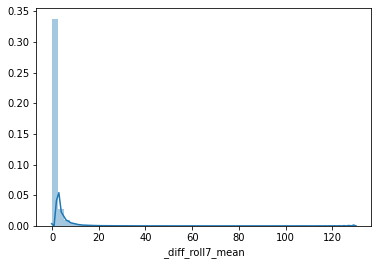

In [28]:
sns.distplot(data._diff_roll7_mean)

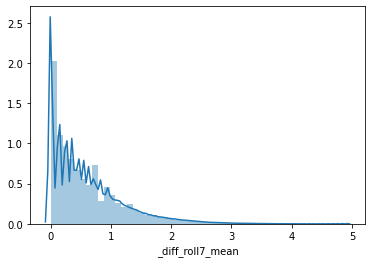

In [29]:
sns.distplot(np.log1p(data._diff_roll7_mean))

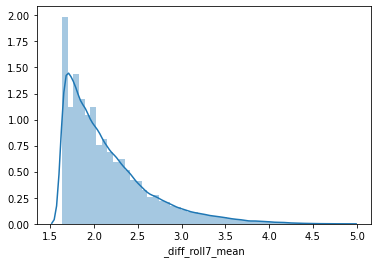

In [30]:
sns.distplot(np.log1p(data[data._diff_roll7_mean>4]._diff_roll7_mean))

In [31]:
a = data[['id', '_diff_roll7_mean']].groupby(['id'])['_diff_roll7_mean'].transform(
    lambda x: x.sort_index().shift(1)
)

In [32]:
a = pd.concat([
    data.TARGET,
    a
],axis=1)

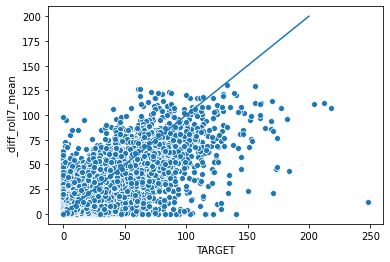

In [33]:
sns.scatterplot(
    data=a,
    x='TARGET',
    y='_diff_roll7_mean'
)
plt.plot([0,200], [0,200])

In [34]:
data[data.TARGET>200]

,d,id,TARGET,d_and_id,item_id,cat_id,dept_id,store_id,state_id,wday,...,abs_diff_1_roll7_mean,abs_diff_28_roll30_mean,_diff_roll7_mean,_diff_roll7_std,_diff_roll7_skew,_diff_pct_roll7,_diff_roll14_mean,_diff_roll14_std,_diff_roll14_skew,_diff_pct_roll14
1520588,1863,FOODS_2_360_WI_2_validation,248.0,1520588,2186,2,5,8,2,1,...,35.428571,11.166667,47.857143,94.022034,2.113637,0.508999,23.928571,68.532378,3.160832,0.349157
2142712,1884,FOODS_3_090_CA_3_validation,218.0,2142712,2314,2,6,2,0,1,...,44.571429,27.566667,112.000000,55.551778,1.401807,2.016137,105.714286,46.696118,1.504984,2.263877
2173202,1885,FOODS_3_090_CA_3_validation,212.0,2173202,2314,2,6,2,0,2,...,35.000000,28.766667,126.714286,67.071391,0.631170,1.889245,112.928571,54.692798,1.130654,2.064780
2813492,1906,FOODS_3_090_CA_3_validation,204.0,2813492,2314,2,6,2,0,2,...,22.857143,28.866667,123.142857,44.827181,1.126569,2.747058,114.428571,37.898070,1.171253,3.019377


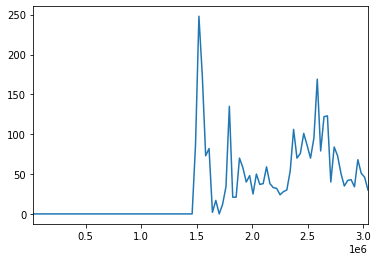

In [35]:
data[data.id=='FOODS_2_360_WI_2_validation'].TARGET.plot()

In [36]:
calendar_df[calendar_df.d==1863]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,,
1863,2016-03-05,11606,Saturday,1,3,2016,1863,NaN,NaN,NaN,NaN,1,1,1


In [37]:
data.TARGET.mean()

1.366514799653625

In [38]:
data.TARGET.std()

3.6137135652246335

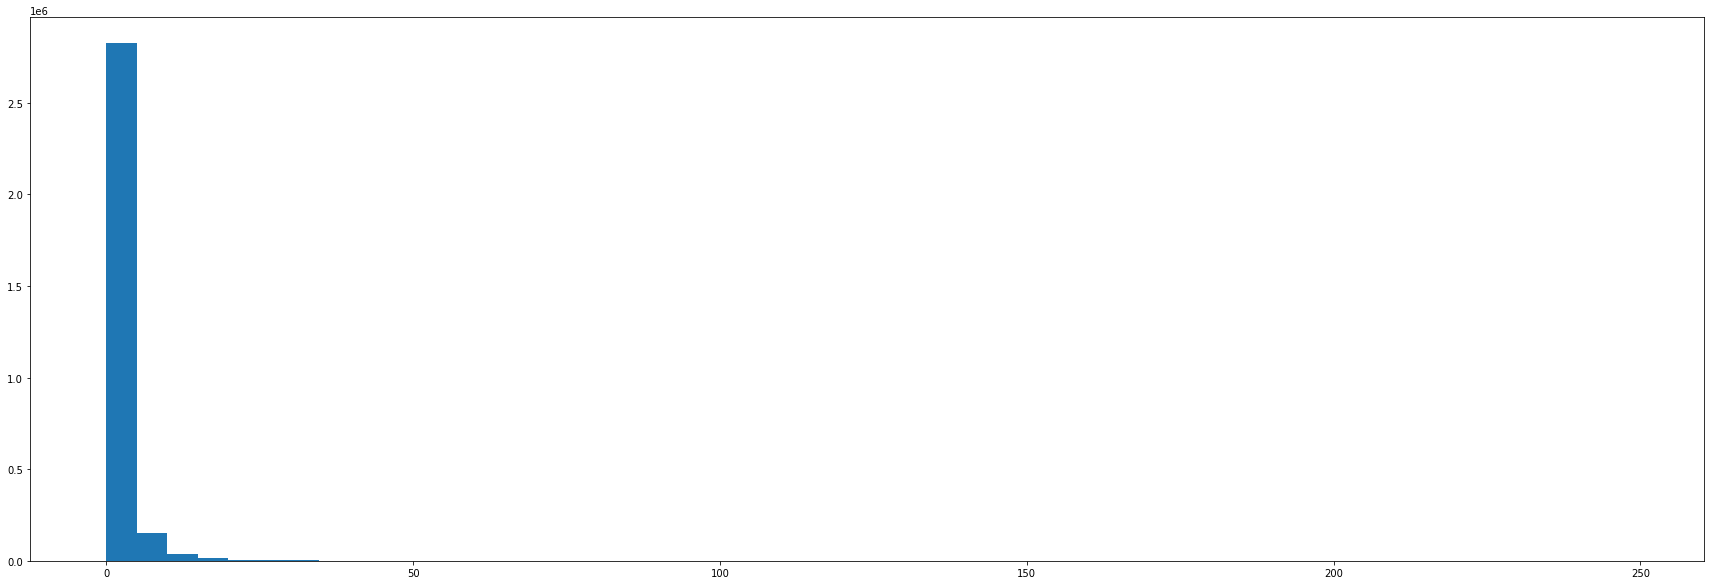

In [39]:
plt.figure(figsize=(30,10))
plt.hist(data.TARGET, bins=50)
plt.show()

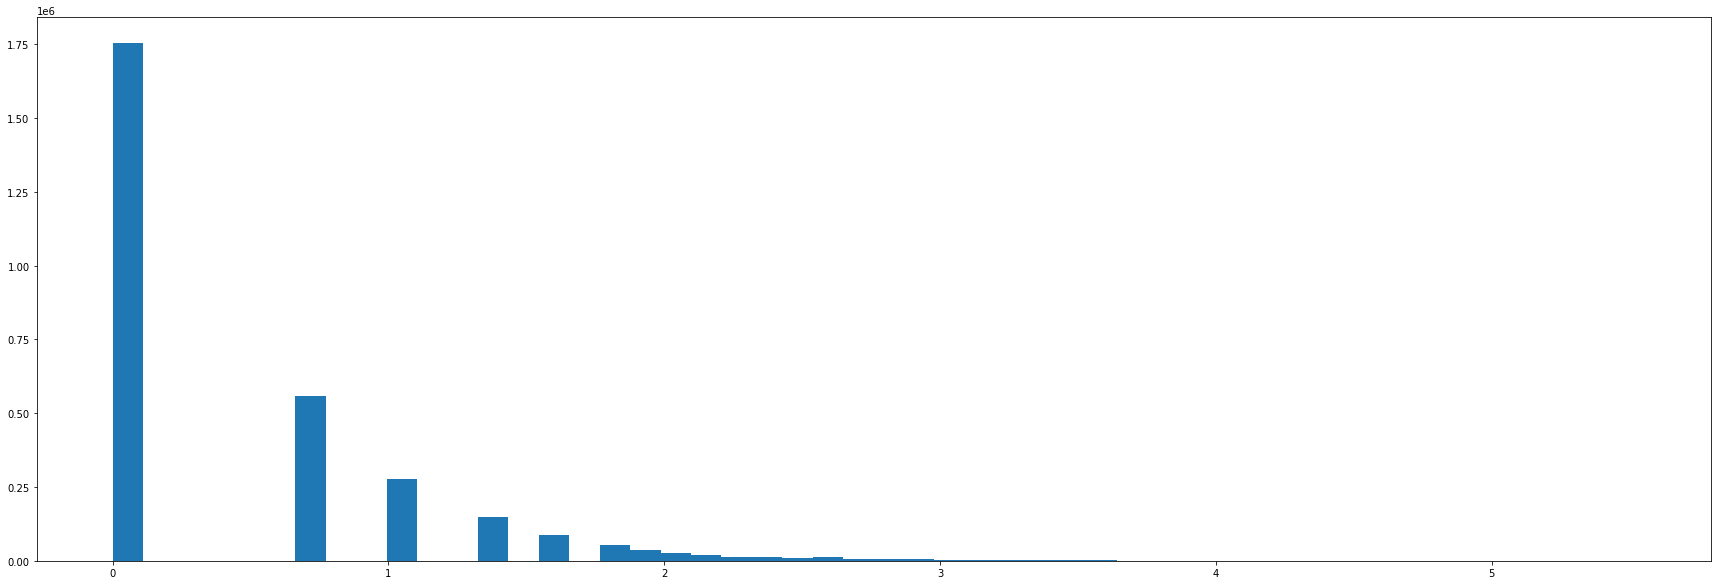

In [40]:
plt.figure(figsize=(30,10))
plt.hist(np.log1p(data.TARGET), bins=50)
plt.show()

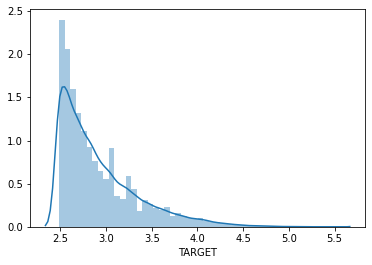

In [41]:
sns.distplot(np.log1p(data[data.TARGET>10].TARGET))

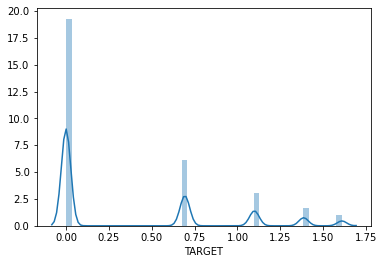

In [42]:
sns.distplot(np.log1p(data[data.TARGET<5].TARGET))

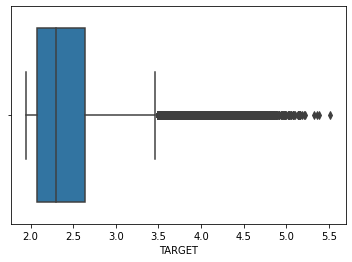

In [43]:
sns.boxplot(np.log1p(data[data.TARGET>5].TARGET))

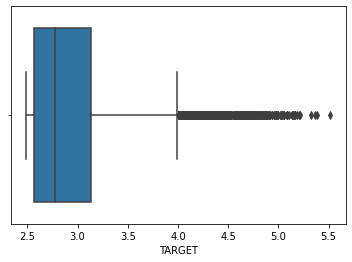

In [44]:
sns.boxplot(np.log1p(data[data.TARGET>10].TARGET))

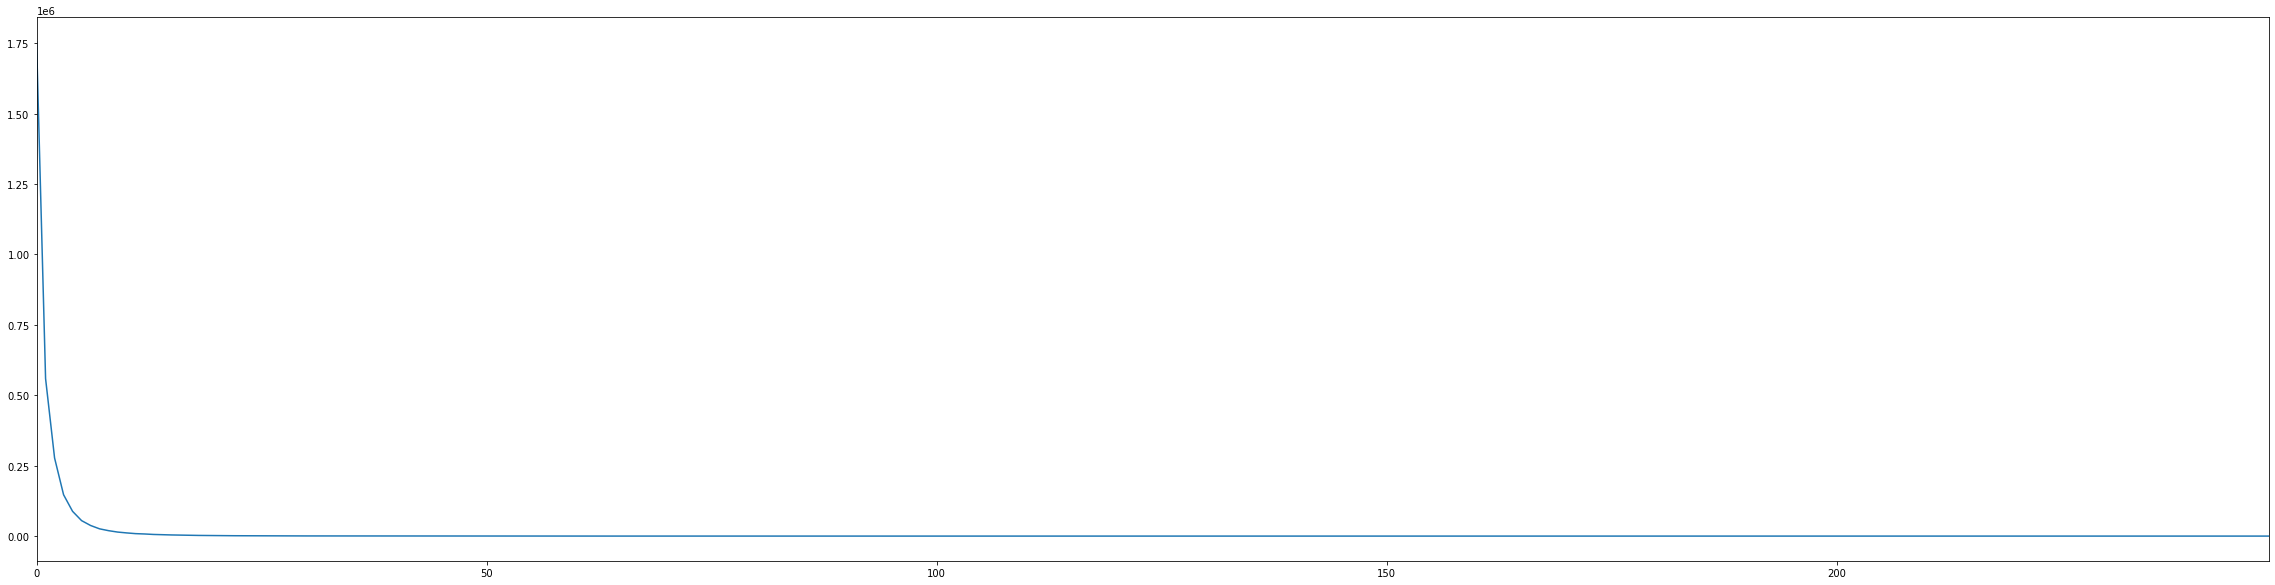

In [45]:
data.TARGET.value_counts().sort_index().plot(figsize=(40,10))

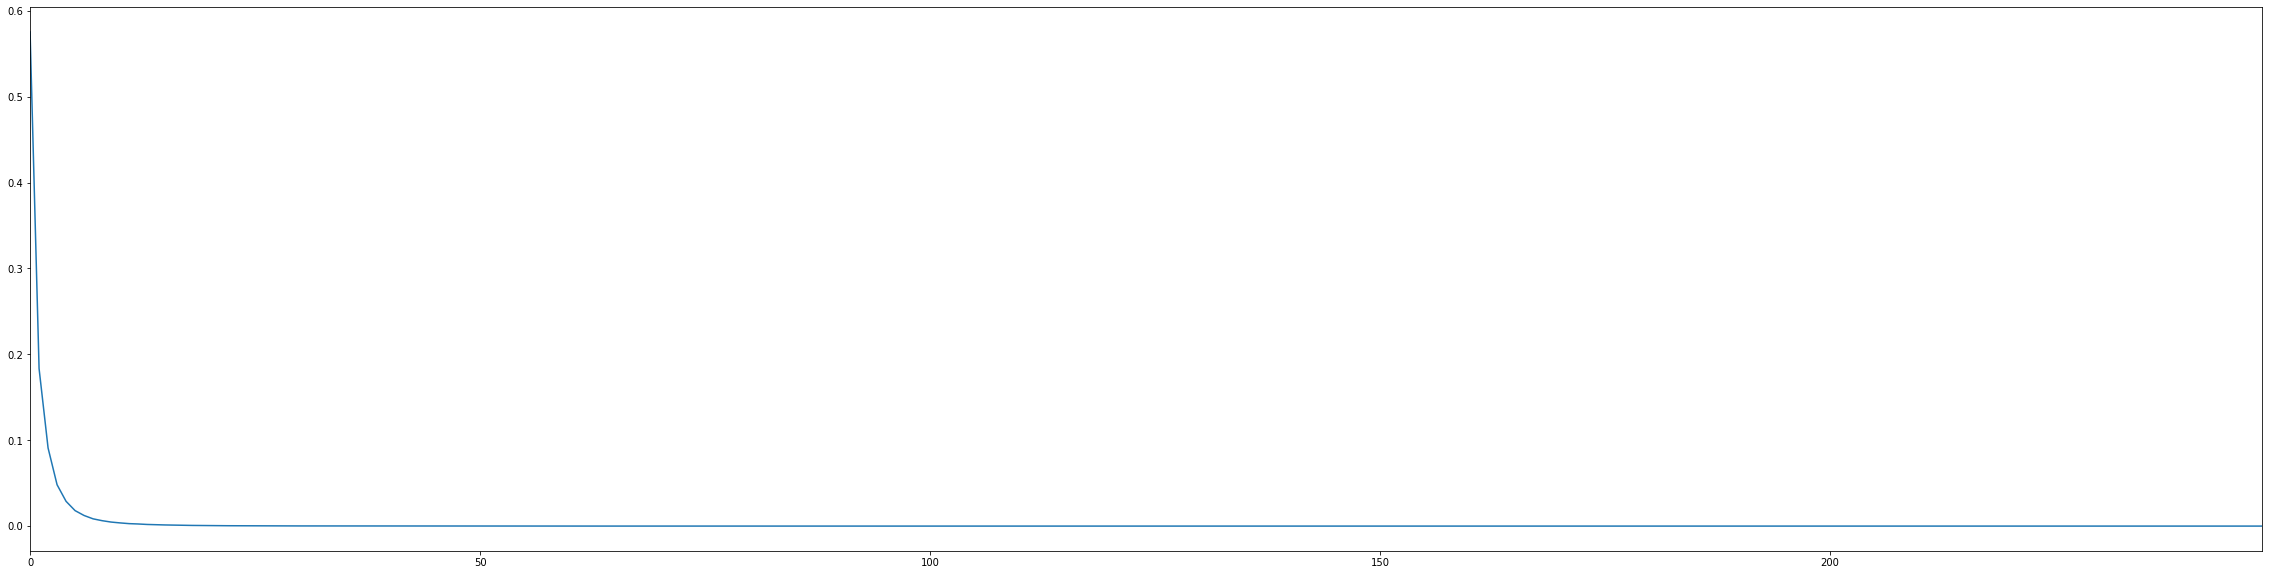

In [46]:
data.TARGET.value_counts(normalize=True).sort_index().plot(figsize=(40,10))

In [47]:
data.TARGET.value_counts(normalize=True)#.sort_index()

0.0      5.754854e-01
1.0      1.834009e-01
2.0      9.094144e-02
3.0      4.814644e-02
4.0      2.882521e-02
             ...     
136.0    3.280065e-07
134.0    3.280065e-07
248.0    3.280065e-07
120.0    3.280065e-07
218.0    3.280065e-07
Name: TARGET, Length: 165, dtype: float64

In [48]:
gc.collect()

11395